Test the correlation between activation values calculated by atemporal and temporal (spiking) methods 

In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [2]:
from phasor_jax.modules import *
from phasor_jax.utils import *
from phasor_jax.training import *

In [3]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key, 2)

In [4]:
n_samples = 1000
n_channels = 128
sample = jax.random.uniform(subkey, shape=(n_samples, n_channels)) 

# Model

In [5]:
"""
Create a simple two-layer MLP model for the test.
"""
def mlp(x, 
           spiking: bool = False,
           **kwargs):
    
    if spiking:
        x = phase_to_train(x)
    
    x1 = conv_1d(n_channels)(x, spiking=spiking, **kwargs)
    x2 = conv_1d(n_channels)(x1,  spiking=spiking, **kwargs)
     
    return x1, x2

In [6]:
#declare the model as a transformation
model = hk.transform(mlp)

In [7]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)

#create two sets of parameters - with and without bias - to test the network
params = model.init(subkey, sample)
params2 = model.init(subkey, sample)

/Users/wilkie/anaconda3/envs/jax/lib/python3.10/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [8]:
#set the bias values on the first set of parameters to zero
params['phasor_dense']['bz'] = jnp.zeros_like(params['phasor_dense']['bz'])
params['phasor_dense_1']['bz'] = jnp.zeros_like(params['phasor_dense_1']['bz'])

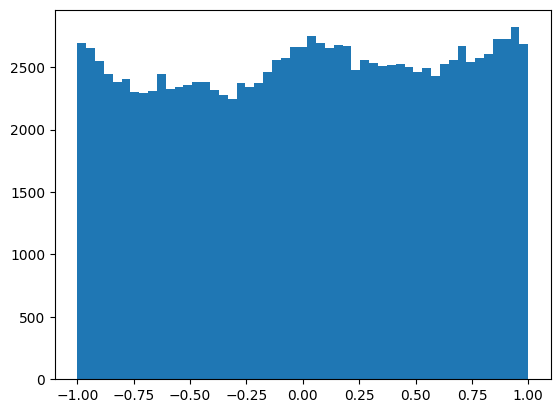

In [9]:
#without a bias value, the activations produced by a phasor neuron are uniformly distributed
l1, l2 = model.apply(params, key, sample, spiking=False)

plt.hist(l1.ravel(), bins=51);

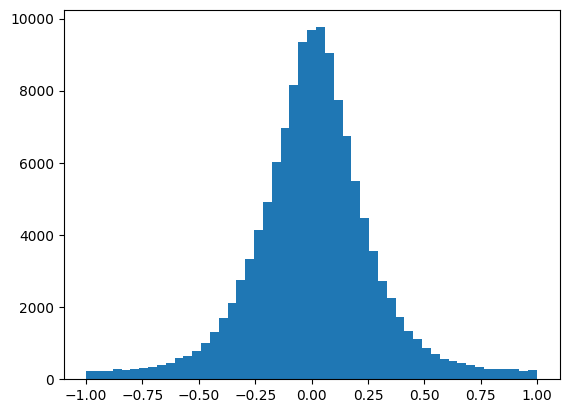

In [10]:
#with bias values, the activations become normally distributed around zero
bl1, bl2 = model.apply(params2, key, sample, spiking=False)

plt.hist(bl1.ravel(), bins=51);

In [11]:
#now, execute the model running in a temporal (spiking) manner
s1, s2 = model.apply(params, key, sample, spiking=True, mask_angle=-1.0)

In [12]:
#calculate the phases represented by the spike trains
sp1 = train_to_phase(s1)
sp2 = train_to_phase(s2)

In [13]:
#calculate the spiking rates of each train for inspection (relative to firing once each cycle)
spiking_rate(s2)

0.63902734375

In [14]:
[pearsonr(l1.ravel(), sp1[...,i].ravel()) for i in range(sp1.shape[-1]-1)]

[PearsonRResult(statistic=0.4788862560359054, pvalue=0.0),
 PearsonRResult(statistic=0.7425278744120289, pvalue=0.0),
 PearsonRResult(statistic=0.8514995459482024, pvalue=0.0),
 PearsonRResult(statistic=0.8610718418199934, pvalue=0.0),
 PearsonRResult(statistic=0.8286560877458462, pvalue=0.0),
 PearsonRResult(statistic=0.779968391162138, pvalue=0.0),
 PearsonRResult(statistic=0.7131778705109684, pvalue=0.0),
 PearsonRResult(statistic=0.6236664769153036, pvalue=0.0),
 PearsonRResult(statistic=0.5103901899201727, pvalue=0.0),
 PearsonRResult(statistic=0.3173865828344431, pvalue=0.0)]

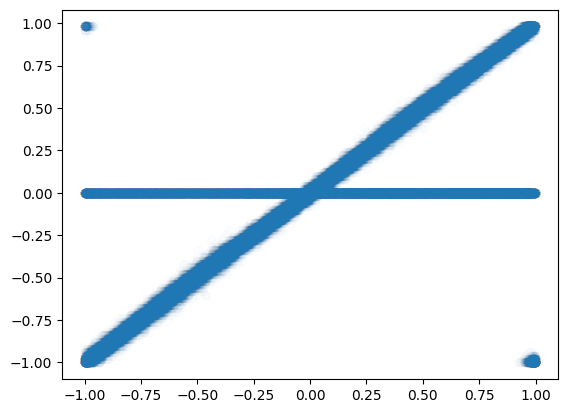

In [15]:
plt.scatter(l1.ravel(), sp1[...,4].ravel(), alpha=0.01)

In [16]:
s2.offset

0.5

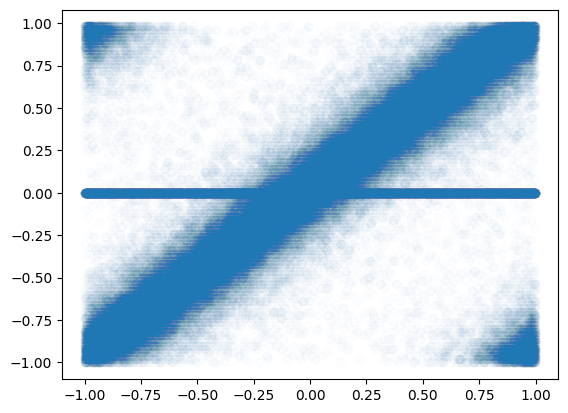

In [17]:
plt.scatter(l2.ravel(), sp2[...,4].ravel(), alpha=0.01)

In [18]:
bs1, bs2 = model.apply(params2, key, sample, spiking=True, mask_angle=-1.0)

In [19]:
st = phase_to_train(sample)

In [20]:
bsp1 = train_to_phase(bs1)

In [36]:
bsp2 = train_to_phase(bs2)

In [22]:
spiking_rate(bs2)

0.8328796875

In [23]:
b_corr1 = [pearsonr(bl1.ravel(), bsp1[...,i].ravel()).statistic for i in range(bsp1.shape[-1]-1)]
b_corr2 = [pearsonr(bl2.ravel(), bsp2[...,i].ravel()).statistic for i in range(bsp2.shape[-1]-1)]

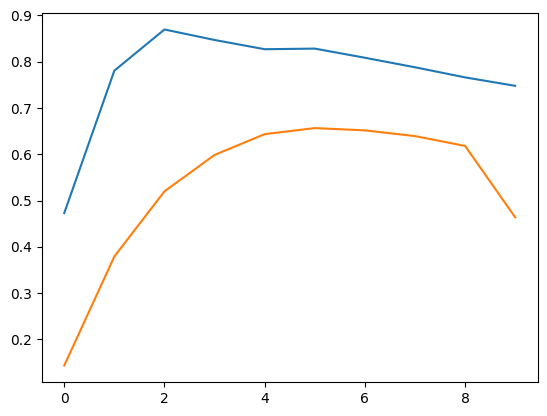

In [24]:
plt.plot(b_corr1)
plt.plot(b_corr2)

In [25]:
bs1.offset

0.25

In [26]:
bs2.offset

0.5

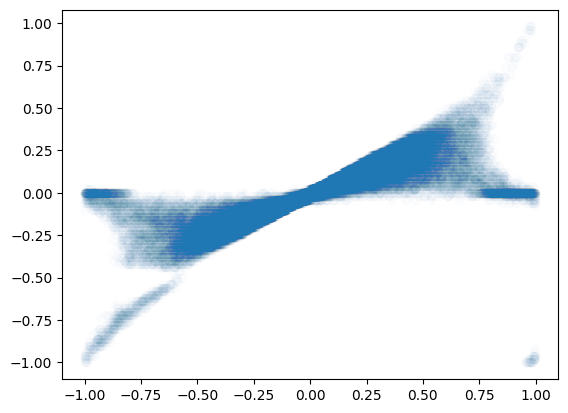

In [27]:
plt.scatter(bl1.ravel(), bsp1[...,4].ravel(), alpha=0.01)

In [28]:
spiking_rate(bs1)

0.9564953125

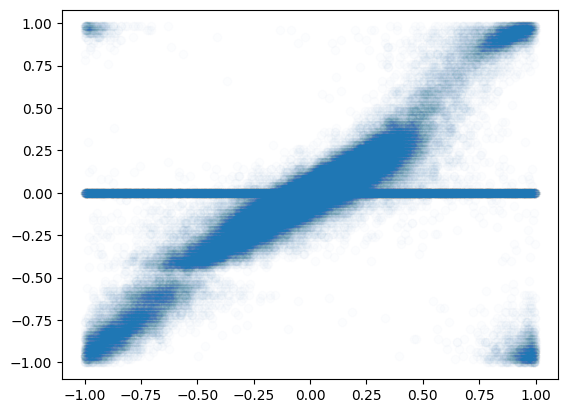

In [29]:
plt.scatter(bl2.ravel(), bsp2[...,4].ravel(), alpha=0.01)

In [30]:
spiking_rate(bs2)

0.8328796875

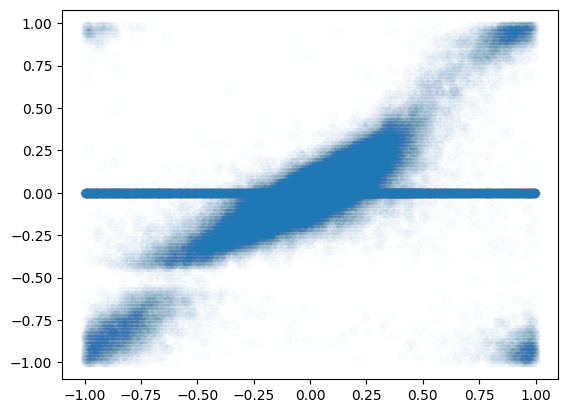

In [31]:
plt.scatter(bl2.ravel(), bsp2[...,2].ravel(), alpha=0.01)

In [34]:
mbs1, mbs2 = model.apply(params2, key, sample, spiking=True, mask_angle=0.1)

In [35]:
print(spiking_rate(mbs1))
print(spiking_rate(mbs2))

0.27306171875
0.2339984375


In [37]:
mbsp1 = train_to_phase(mbs1)
mbsp2 = train_to_phase(mbs2)

In [39]:
mb_corr1 = [pearsonr(bl1.ravel(), mbsp1[...,i].ravel()).statistic for i in range(mbsp1.shape[-1]-1)]
mb_corr2 = [pearsonr(bl2.ravel(), mbsp2[...,i].ravel()).statistic for i in range(mbsp2.shape[-1]-1)]

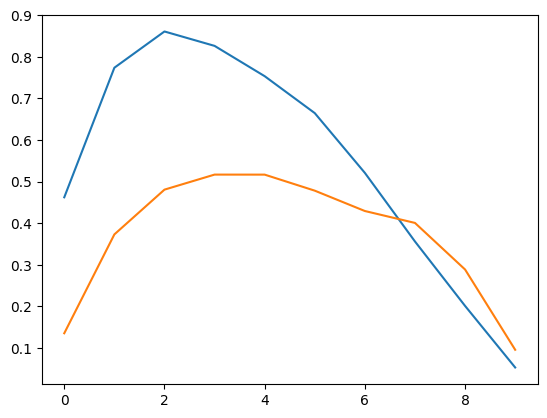

In [40]:
plt.plot(mb_corr1)
plt.plot(mb_corr2)

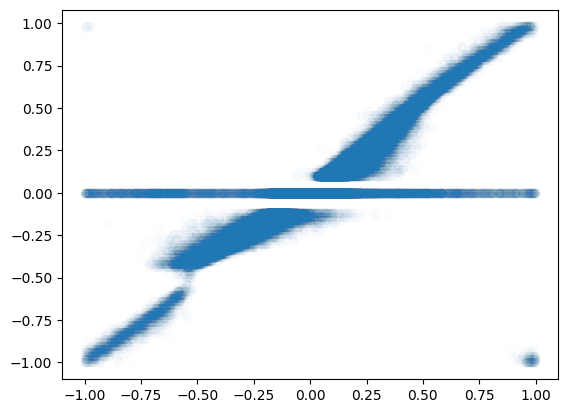

In [42]:
plt.scatter(bl1.ravel(), mbsp1[...,2].ravel(), alpha=0.01)

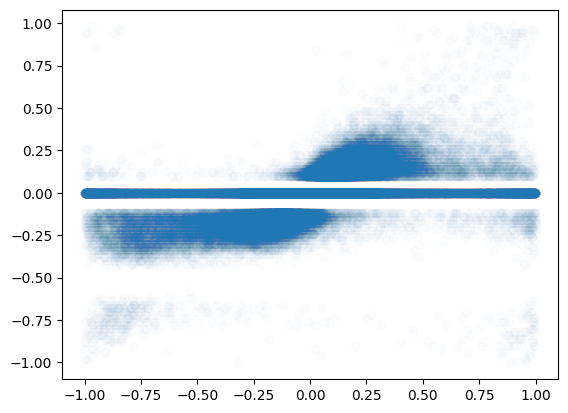

In [41]:
plt.scatter(bl2.ravel(), mbsp2[...,2].ravel(), alpha=0.01)

In [ ]:
spiking_rate(bs2)

0.8328796875

In [ ]:
b_corr1 = [pearsonr(bl1.ravel(), bsp1[...,i].ravel()).statistic for i in range(bsp1.shape[-1]-1)]
b_corr2 = [pearsonr(bl2.ravel(), bsp2[...,i].ravel()).statistic for i in range(bsp2.shape[-1]-1)]